In [1]:
import sys
sys.path.append('/home/potzschf/repos/')
from helperToolz.helpsters import *
from helperToolz.dicts_and_lists import *
from helperToolz.guzinski import * 
from other_repos.pyDMS.pyDMS.pyDMS import *
import time

In [2]:
base_path = '/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/tempDump2/ff3f2c872c08977466e5a8dc306d2d2aabc77ad995b0716c30d1c57d0004ebfd/'

highResFilename = f'{base_path}HIGHRES_maxLST_2019_July_19_watermask_S2_agromask.tif'
lowResFilename = f'{base_path}Daily_LST_maxLST_2019_July_19.tif'
lowResMaskFilename = ''
cv = 0
movWin = 15
regrat = 75
outputFilename = f'/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/DEBUG/DEBUG_TEST_{cv}_{movWin}_{regrat}.tif'
useDecisionTree = True


commonOpts = {"highResFiles":               [highResFilename],
                "lowResFiles":              [lowResFilename],
                "lowResQualityFiles":         [lowResMaskFilename],
                "lowResGoodQualityFlags":     [1],
                "cvHomogeneityThreshold":     cv,
                "movingWindowSize":           movWin,
                "disaggregatingTemperature":  True}
dtOpts =     {"perLeafLinearRegression":    True,
                "linearRegressionExtrapolationRatio": round(regrat, 2)}
sknnOpts =   {'hidden_layer_sizes':         (10,),
                'activation':                 'tanh'}
nnOpts =     {"regressionType":             REG_sklearn_ann,
                "regressorOpt":               sknnOpts}

start_time = time.time()
opts = commonOpts.copy()
if useDecisionTree:
    opts.update(dtOpts)
    disaggregator = DecisionTreeSharpener(**opts)
else:
    opts.update(nnOpts)
    disaggregator = NeuralNetworkSharpener(**opts)


In [3]:
print("Training regressor...")
disaggregator.trainSharpener()

Training regressor...


/data/Aldhani/users/potzschf/conda/envs/workhorse/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Homogeneity CV threshold: 1.61
Number of training elements for is 30 representing 96% of avaiable low-resolution data.
Homogeneity CV threshold: 1.53
Number of training elements for is 16 representing 100% of avaiable low-resolution data.
Homogeneity CV threshold: 2.50
Number of training elements for is 15 representing 93% of avaiable low-resolution data.
Homogeneity CV threshold: 1.26
Number of training elements for is 13 representing 92% of avaiable low-resolution data.
Homogeneity CV threshold: 1.22
Number of training elements for is 99 representing 95% of avaiable low-resolution data.
Homogeneity CV threshold: 1.29
Number of training elements for is 92 representing 93% of avaiable low-resolution data.
Homogeneity CV threshold: 1.26
Number of training elements for is 93 representing 100% of avaiable low-resolution data.
Homogeneity CV threshold: 1.15
Number of training elements for is 14 representing 100% of avaiable low-resolution data.
Homogeneity CV threshold: 0.93
Number of trai

In [4]:
highResFile = gdal.Open(highResFilename)
inData = np.zeros((highResFile.RasterYSize, highResFile.RasterXSize,
                    highResFile.RasterCount))
for band in range(highResFile.RasterCount):
    data = highResFile.GetRasterBand(band+1).ReadAsArray().astype(float)
    no_data = highResFile.GetRasterBand(band+1).GetNoDataValue()
    data[data == no_data] = np.nan
    inData[:, :, band] = data
gt = highResFile.GetGeoTransform()

shape = inData.shape
ysize = shape[0]
xsize = shape[1]

# Temporarly get rid of NaN's
nanInd = np.isnan(inData)
inData[nanInd] = 0

outWindowData = np.empty((ysize, xsize))*np.nan
outFullData = np.empty((ysize, xsize))*np.nan

In [5]:
# Do the downscailing on the moving windows if there are any and also process the full
# scene using the same windows to optimize memory usage
for i, extent in enumerate(disaggregator.windowExtents):
    print(i)
    if disaggregator.reg[i] is not None:
        [minX, minY] = utils.point2pix(extent[0], gt)  # UL
        [minX, minY] = [max(minX, 0), max(minY, 0)]
        [maxX, maxY] = utils.point2pix(extent[1], gt)  # LR
        [maxX, maxY] = [min(maxX, xsize), min(maxY, ysize)]
        windowInData = inData[minY:maxY, minX:maxX, :]
        outWindowData[minY:maxY, minX:maxX] = \
            disaggregator._doPredict(windowInData, disaggregator.reg[i])
        if disaggregator.reg[-1] is not None:
            outFullData[minY:maxY, minX:maxX] = \
                disaggregator._doPredict(windowInData, disaggregator.reg[-1])

# If there were no moving windows then do the downscailing on the whole input image
if np.all(np.isnan(outFullData)) and disaggregator.reg[-1] is not None:
    outFullData = disaggregator._doPredict(inData, disaggregator.reg[-1])

0
1
2
3
4
5
6
7
8
9
10
11


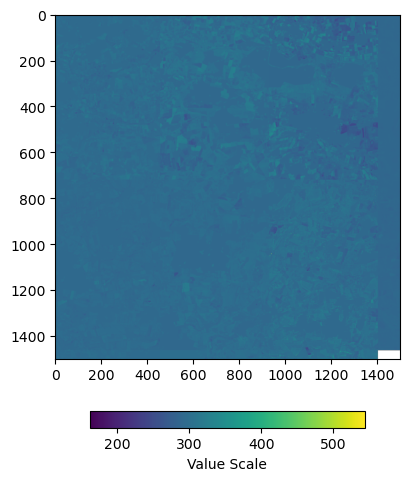

In [6]:
plotter(outWindowData)

In [8]:
lowResScene = gdal.Open(lowResFilename)
outWindowScene = utils.saveImg(outWindowData,
                                highResFile.GetGeoTransform(),
                                highResFile.GetProjection(),
                                "MEM",
                                noDataValue=np.nan)
# windowedResidual_LR, gt_LR 
# outWindowScene = None

In [9]:
downscaledScene = outWindowScene
originalScene = lowResScene
                    
# First subset and reproject original (low res) scene to fit with
# downscaled (high res) scene
subsetScene_LR = utils.reprojectSubsetLowResScene(downscaledScene,
                                                    originalScene,
                                                    resampleAlg=gdal.GRA_NearestNeighbour)
data_LR = subsetScene_LR.GetRasterBand(1).ReadAsArray().astype(float)
gt_LR = subsetScene_LR.GetGeoTransform()


# Then resample high res scene to low res pixel size
# When working with tempratures they should be converted to
# radiance values before aggregating to be physically accurate.
radianceScene = utils.saveImg(downscaledScene.GetRasterBand(1).ReadAsArray()**4,
                                downscaledScene.GetGeoTransform(),
                                downscaledScene.GetProjection(),
                                "MEM",
                                noDataValue=np.nan)
resMean, _ = utils.resampleHighResToLowRes(radianceScene,
                                            subsetScene_LR)
# Find the residual (difference) between the two)
residual_LR = data_LR - resMean[:, :, 0]**0.25

windowedResidual_LR = residual_LR
outWindowScene = None
       

In [11]:
outFullScene = utils.saveImg(outFullData,
                                        highResFile.GetGeoTransform(),
                                        highResFile.GetProjection(),
                                        "MEM",
                                        noDataValue=np.nan)

In [14]:
fullResidual_LR, gt_LR = disaggregator._calculateResidual(outFullScene, lowResScene)

In [ ]:
           
lowResScene = None
# windowed weight
ww_LR = (1/windowedResidual_LR)**2/((1/windowedResidual_LR)**2 +
                                    (1/fullResidual_LR)**2)
wwLowResScene = utils.saveImg(ww_LR,
                                gt_LR,
                                highResFile.GetProjection(),
                                "MEM",
                                noDataValue=np.nan)
ww = utils.resampleLowResToHighRes(wwLowResScene, outFullScene)
ww = np.clip(ww, 0.0, 1.0)
# full weight
fw = 1 - ww

outData = ((outWindowData**4)*ww + (outFullData**4)*fw)**0.25

      

# Fix NaN's
nanInd = np.any(nanInd, -1)
outData[nanInd] = np.nan

outImage = utils.saveImg(outData,
                            highResFile.GetGeoTransform(),
                            highResFile.GetProjection(),
                            "MEM",
                            noDataValue=np.nan)

highResFile = None
inData = None
    

In [ ]:

print("Training regressor...")
disaggregator.trainSharpener()
print("Sharpening...")
downscaledFile = disaggregator.applySharpener(highResFilename, lowResFilename)
print("Residual analysis...")
residualImage, correctedImage = disaggregator.residualAnalysis(downscaledFile, lowResFilename,
                                                                lowResMaskFilename,
                                                                doCorrection=True)
print("Saving output...")

if correctedImage is not None:
    outImage = correctedImage
else:
    outImage = downscaledFile
# outData = utils.binomialSmoother(outData)
outFile = utils.saveImg(outImage.GetRasterBand(1).ReadAsArray(),
                        outImage.GetGeoTransform(),
                        outImage.GetProjection(),
                        f'{os.path.split(outputFilename)[0]}/Values/{os.path.split(outputFilename)[1]}')
residualFile = utils.saveImg(residualImage.GetRasterBand(1).ReadAsArray(),
                            residualImage.GetGeoTransform(),
                            residualImage.GetProjection(),
                            f'{os.path.split(outputFilename)[0]}/Residuals/{os.path.split(outputFilename)[1]}_resid{os.path.splitext(outputFilename)[1]}')

outFile = None
residualFile = None
downsaceldFile = None
